# HW02 - Mourning Tweets

## Import Data

In [1]:
# Import Libraries
import nltk
import csv
import string
import numpy as np
import pandas as pd

from IPython.display import clear_output

In [2]:
# Download nltk corpus
#nltk.download()

# Import fnmourning dataset
raw_df = pd.read_csv('./data/fnmourning.csv', sep = ',')

# Set pandas columns option
pd.set_option('display.max_colwidth', 1000)
pd.set_option("max_rows", 30)

# Glimpse to raw dataset
raw_df.head(10)

,text,tag,lang,emoticon
0,"Hoy uno de mis tíos falleció por COVID-19, no lo escribo para que me manden sus condolencias ni muchos. Sino, para hacer conciencia y sepan que esto es REAl, que dejen de minimizar lo que está pasando y se den cuenta de la gravedad de todo esto.",mourning,es,0
1,"Hoy falleció mi abuela. Y eso, sin velorio, sin poder abrazarnos, sin nada. Porfa cumplan la cuarentena, porque desde esta perspectiva todo es muy horrible",mourning,es,0
2,Muere el primer médico en activo por Covid-19 en Sevilla. Se nos va un gran profesional y mejor persona. Mi más sentido pésame a su familia y un abrazo enorme Joaquin. Te echaremos mucho de https://t.co/RmTnahE1ay sé cómo expresar la tristeza que siento https://t.co/5qelhdN0cm,mourning,es,0
3,"Historia de una victoria. Historia de los últimos momentos de quienes no la alcazaron, como mi tito Pepe de Alcalá de Henares. Descansad en Paz. Todo nuestro respeto 🙏\n \n https://t.co/mpRj8n0OVv",mourning,es,1
4,"He visto dos personas a las que les tomé cariño morir a causa del coronavirus en los últimos 9 días, hoy falleció el que más aprecio pudo obtener de mi persona. No tengo palabras",mourning,es,0
5,Gran tristeza se siente Q.E.P.D. Gran ser humano que se lleva el COVID-19 😭,mourning,es,1
6,"de 30.600 profesionales sanitarios infectados por el coronavirus. El Consejo General de Colegios Oficiales de Médicos de España (CGCOM) expresa su reconocimiento a su entrega y servicio a los demás y expresa sus condolencias a las familias y compañeros: ""Nunca os olvidaremos""",mourning,es,0
7,¡Qué triste! 😔Los hermanos Morales perdieron la batalla contra el #coronavirus y sus familiares solo quieren que descansen en paz en donde siempre lo desearon💔Mira su triste historia 🎥 \n https://t.co/YfRmxf40zM,mourning,es,1
8,"El día 23 de abril, falleció la actriz de doblaje Kumiko Okae por la pandemia de covid-19, Kumiko era conocida por participar en El Regreso del gato (Película de #StudioGhibli) dando voz a la madre de Haru, también fue la voz de Jenny en pokémon: Lucario y el misterio de mew. 😓 https://t.co/2fFryf1bR9",mourning,es,1
9,"Panamá tiene 5338 casos de coronavirus, 172 más que ayer, y se reportan 8 nuevas defunciones 😔, para un total de 154 fallecidos QEPD 🙏",mourning,es,1


In [3]:
# Replace string tags with binary tags
raw_df.tag = raw_df.tag.replace('mourning',1)
raw_df.tag = raw_df.tag.replace('no mourning',0)

# Split dataset by language
es_df = raw_df[(raw_df.lang == "es")]
en_df = raw_df[(raw_df.lang == "en")]

## Mourning Lexicons

### Process Tweets

In [4]:
# Tweet tokenizer 
from gensim.parsing.preprocessing import remove_stopwords
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

def process_tweet(tokenizer, stemmer, tweet, stop_words):
    """ Applies standard pre-processing to given tweet.
    
    Args:
        text (str): tweet to preprocess.
        language (str): languague of the tweet.
        stop_words (str): list of words to be removed.
    
    Returns:
        list: preprocessed text.
    
    """
    
    # Remove punctuations and convert characters to lower case
    tweet_nopunct = "".join([char.lower() for char in tweet if char not in string.punctuation]) 
    
    # Tokenize words
    tk_tweet = tokenizer.tokenize(tweet_nopunct)
    
    # Remove stop words
    relevant_words=[]
    for word in tk_tweet:
        if word not in stop_words:
            relevant_words.append(word)
            
    # Stem relevant words
    #processed_tweet=[]
    #for word in relevant_words:
    #    processed_tweet.append(stemmer.stem(word))
    
    #print(processed_tweet)
    
    # Returns processed text
    return relevant_words

In [5]:
# Creates tweet tokenizer
tt = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

# Tokenize tweets in ES dataset
es_stemmer = SnowballStemmer('spanish')
es_stop_words = stopwords.words('spanish')
es_tweets = []
for tweet in es_df.text:
    # Tokenize tweets
    es_tweets.append(process_tweet(tt, es_stemmer, tweet, es_stop_words))

# Tokenize tweets in EN dataset
en_stemmer = SnowballStemmer('english')
en_stop_words = stopwords.words('english')
en_tweets = []
for tweet in en_df.text:
    # Tokenize tweets
    en_tweets.append(process_tweet(tt, en_stemmer, tweet, en_stop_words))

In [6]:
# Build dictionaries
from gensim import corpora

# Convert tweets to ES dictionary
es_dict = corpora.Dictionary(es_tweets)
# Filter extremes
es_dict.filter_extremes(no_below=5, no_above=0.5)

# Convert tweets to ES dictionary
en_dict = corpora.Dictionary(en_tweets)
# Filter extremes
en_dict.filter_extremes(no_below=5, no_above=0.5)

# Glimpse to dictionaries
print('ES Dictionary:')
print(es_dict)
print('')
print('EN Dictionary:')
print(en_dict)

ES Dictionary:
Dictionary(4738 unique tokens: ['19', 'conciencia', 'condolencias', 'covid', 'cuenta']...)

EN Dictionary:
Dictionary(4194 unique tokens: ['19', 'away', 'continue', 'covid', 'created']...)


In [7]:
# Create BOW Representation of each tweet
es_corpus = []
en_corpus = []

# ES tweets
for tweet in es_tweets:
    es_corpus.append(es_dict.doc2bow(tweet))
    
# EN tweets
for tweet in en_tweets:
    en_corpus.append(en_dict.doc2bow(tweet))

### Build Lexicons

In [8]:
def create_lexicons(dictionary, tweet_corpus, tags):
    """ Create lexicons for mourning tweets.
    
    Args:
        dictionary (gensim.corpora.dictionary.Dictionary): Dictionary for the es_.
        tweet_corpus (gensim.corpora.mmcorpus.MmCorpus): Tweet corpus with tweets in BOW Model.
        tags (numpy.array): Array with mourning tags (1=Mourning, 0=No mourning).
    
    Returns:
        pos (numpy.array): Negative score of each term.
        neg (numpy.array): Positive score of each term.
    
    """
    
    # Create pos/neg arrays
    pos_count = np.zeros(len(dictionary))
    neg_count = np.zeros(len(dictionary)) 
    
    # Tweet corpus loop
    for i, tweet in enumerate(tweet_corpus):
        
        # Term loop
        for term in tweet:
            
            # Add to pos/neg array by tag
            if tags[i]:
                pos_count[term[0]] += term[1]
                #pos_count[term[0]] += 1
            else:
                neg_count[term[0]] += term[1]
                #neg_count[term[0]] += 1

    #p_w = (pos_count+neg_count)/sum(pos_count+neg_count)
    p_w = (pos_count+neg_count)/len(pos_count)
    
    # Calculate likelihood
    #pos_score = (pos_count/(pos_count+neg_count))*p_w
    #neg_score = (neg_count/(pos_count+neg_count))*p_w
    pos_score = pos_count/sum(pos_count)
    neg_score = neg_count/sum(neg_count)
    
    # Convert to scaled likelihood
    pos_score_scaled = pos_score/(pos_score + neg_score)
    neg_score_scaled = neg_score/(pos_score + neg_score)

    # Return pos/neg score of terms
    return pos_score, neg_score, pos_score_scaled, neg_score_scaled

In [9]:
# Retrieve scores for each language
es_pos, es_neg, es_pos_sc, es_neg_sc = create_lexicons(es_dict, es_corpus, es_df.tag.values)
en_pos, en_neg, en_pos_sc, en_neg_sc = create_lexicons(en_dict, en_corpus, en_df.tag.values)

In [10]:
# Initial dataframe with terms
es_lexicons = pd.DataFrame(list(es_dict.token2id.items()), columns = ['Term','Id'])
en_lexicons = pd.DataFrame(list(en_dict.token2id.items()), columns = ['Term','Id'])

# Add Pos/Neg Scores
es_lexicons['P(w|c=1)'] = es_pos
es_lexicons['P(w|c=0)'] = es_neg

en_lexicons['P(w|c=1)'] = en_pos
en_lexicons['P(w|c=0)'] = en_neg

# Add Pos/Neg Scores Scaled
es_lexicons['P(c=1|w)'] = es_pos_sc
es_lexicons['P(c=0|w)'] = es_neg_sc

en_lexicons['P(c=1|w)'] = en_pos_sc
en_lexicons['P(c=0|w)'] = en_neg_sc

In [11]:
# Print top 15 words by likelihood
es_lexicons.sort_values(by='P(w|c=1)', ascending=False).drop(columns=['Id']).head(15)

,Term,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w)
2,condolencias,0.018370,0.000351,0.981245,0.018755
65,qepd,0.018253,0.000836,0.956206,0.043794
252,pesar,0.015204,0.000084,0.994531,0.005469
3,covid,0.013584,0.026685,0.337333,0.662667
0,19,0.013409,0.024595,0.352831,0.647169
370,pena,0.012446,0.000468,0.963749,0.036251
17,cuarentena,0.012184,0.018375,0.398689,0.601311
27,familia,0.012154,0.001622,0.882271,0.117729
54,coronavirus,0.009878,0.022639,0.303782,0.696218
434,dolor,0.009061,0.000435,0.954219,0.045781


In [12]:
# Print top 15 words by scaled likelihood
es_lexicons.sort_values(by=['P(c=1|w)','P(w|c=1)'], ascending=False).drop(columns=['Id']).head(15)

,Term,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w)
2014,edelamadrid,0.001576,0.0,1.0,0.0
2022,cordero,0.001269,0.0,1.0,0.0
2015,paloma,0.001240,0.0,1.0,0.0
2693,paul,0.000846,0.0,1.0,0.0
405,qdep,0.000730,0.0,1.0,0.0
337,enviamos,0.000482,0.0,1.0,0.0
4512,sincere,0.000423,0.0,1.0,0.0
1996,irreparable,0.000365,0.0,1.0,0.0
4541,lequioa,0.000350,0.0,1.0,0.0
540,expresamos,0.000336,0.0,1.0,0.0


In [13]:
# Print top 15 words by likelihood
en_lexicons.sort_values(by='P(w|c=1)', ascending=False).drop(columns=['Id']).head(15)

,Term,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w)
3,covid,0.029903,0.042283,0.414251,0.585749
10,rip,0.026358,0.003779,0.874612,0.125388
0,19,0.025728,0.039505,0.394398,0.605602
55,’,0.016292,0.018356,0.470218,0.529782
19,coronavirus,0.014842,0.027124,0.353669,0.646331
81,peace,0.012336,0.004481,0.733561,0.266439
82,rest,0.011750,0.001120,0.912965,0.087035
41,condolences,0.011648,0.001060,0.916555,0.083445
192,🙏,0.011589,0.002240,0.838001,0.161999
142,family,0.010989,0.001822,0.857762,0.142238


In [14]:
# Print top 15 words by scaled likelihood
en_lexicons.sort_values(by=['P(c=1|w)','P(w|c=1)'], ascending=False).drop(columns=['Id']).head(15)

,Term,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w)
2932,roy,0.003209,0.0,1.0,0.0
2933,siegfried,0.001289,0.0,1.0,0.0
3841,belly,0.000498,0.0,1.0,0.0
327,shaikh,0.000440,0.0,1.0,0.0
288,succumbed,0.000396,0.0,1.0,0.0
1900,magic,0.000322,0.0,1.0,0.0
65,warren,0.000293,0.0,1.0,0.0
3119,vasudevan,0.000278,0.0,1.0,0.0
3386,stiller,0.000278,0.0,1.0,0.0
1348,jerry,0.000264,0.0,1.0,0.0


In [15]:
# Proposed list of Mourning words for ES
es_lexicons['ProposedScore'] = es_lexicons['P(w|c=1)'].values - es_lexicons['P(w|c=0)'].values
en_lexicons['ProposedScore'] = en_lexicons['P(w|c=1)'].values - en_lexicons['P(w|c=0)'].values

In [16]:
es_lexicons.sort_values(by=['ProposedScore'], ascending=False).drop(columns=['Id']).head(15)

,Term,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),ProposedScore
2,condolencias,0.018370,0.000351,0.981245,0.018755,0.018019
65,qepd,0.018253,0.000836,0.956206,0.043794,0.017417
252,pesar,0.015204,0.000084,0.994531,0.005469,0.015120
370,pena,0.012446,0.000468,0.963749,0.036251,0.011978
27,familia,0.012154,0.001622,0.882271,0.117729,0.010533
434,dolor,0.009061,0.000435,0.954219,0.045781,0.008626
50,🙏,0.007719,0.001120,0.873259,0.126741,0.006598
325,dep,0.006785,0.001371,0.831894,0.168106,0.005414
36,pésame,0.005647,0.000451,0.925971,0.074029,0.005195
338,fallecimiento,0.004611,0.000251,0.948411,0.051589,0.004360


In [17]:
en_lexicons.sort_values(by=['ProposedScore'], ascending=False).drop(columns=['Id']).head(15)

,Term,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),ProposedScore
10,rip,0.026358,0.003779,0.874612,0.125388,0.022579
82,rest,0.011750,0.001120,0.912965,0.087035,0.010630
41,condolences,0.011648,0.001060,0.916555,0.083445,0.010587
763,sorry,0.009685,0.000164,0.983318,0.016682,0.009520
192,🙏,0.011589,0.002240,0.838001,0.161999,0.009349
142,family,0.010989,0.001822,0.857762,0.142238,0.009166
62,lost,0.009435,0.001120,0.893878,0.106122,0.008315
265,loss,0.008674,0.000448,0.950878,0.049122,0.008226
81,peace,0.012336,0.004481,0.733561,0.266439,0.007856
145,may,0.008454,0.002599,0.764868,0.235132,0.005855


## Classifiers

In [18]:
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

import copy

### Feature representation

In [19]:
def build_feature_representation(dictionary, corpus, remove_emojis=False, emoji_list=None):
    """ Build BOW Model Matrix representation for tweets in corpus.
    
    Args:
        dictionary (gensim.corpora.dictionary.Dictionary): Dictionary for the tweet corpus.
        tweet_corpus (gensim.corpora.mmcorpus.MmCorpus): Tweet corpus with tweets in BOW Model.
        remove_emojis (boolean): Whether to remove or not to remove emojis from dictionary.
        emoji_list (list): Emojis to be removed from the dictionary (only used if remove_emojis = True)
    
    Returns:
        X (numpy.array): Boolean BOW Model Matrix for tweets in corpus.
    
    """
    
    # Empty Matrix with BOW Model for each corpus
    X = np.zeros((len(corpus), len(dictionary)), dtype = np.int32)
    
    # Fill Input Matrix
    for i, tweet in enumerate(corpus):
        for term in tweet:
            X[i][term[0]] = term[1]
            
    # Remove emojis
    emoji_ids = []
    
    if remove_emojis:
        # Get Emoji IDs for Dictionary
        for emoji in emoji_list:
            try:
                emoji_ids.append(dictionary.token2id[emoji])
            except:
                pass
        
        print('# of removed emojis: '+str(len(emoji_ids)))
        
        # Delete Emoji Columns on X Matrix
        X = np.delete(X, emoji_ids, 1)            
            
    return X, emoji_ids

In [20]:
# Build Boolean BOW Model WITH Emojis
X_es, _ = build_feature_representation(es_dict, es_corpus)
X_en, _ = build_feature_representation(en_dict, en_corpus)

In [21]:
# Import emoji list (Download emoji Module)
from emoji import UNICODE_EMOJI

# Merge ES and EN Emoji List
emoji_list = list({**UNICODE_EMOJI['en'], **UNICODE_EMOJI['es']}.keys())

# Build Boolean BOW Model WITHOUT Emojis
X_es_no_emojis, es_emoji_ids = build_feature_representation(es_dict, es_corpus, remove_emojis=True, emoji_list=emoji_list)
X_en_no_emojis, en_emoji_ids = build_feature_representation(en_dict, en_corpus, remove_emojis=True, emoji_list=emoji_list)

# of removed emojis: 183
# of removed emojis: 139


### Emoji Scores

In [22]:
# Print top 15 ES Emojis by likelihood
es_emoji_mask = es_lexicons['Id'].isin(es_emoji_ids)
es_lexicons.loc[es_emoji_mask].sort_values(by='P(w|c=1)', ascending=False).drop(columns=['Id']).head(15)

,Term,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),ProposedScore
50,🙏,0.007719,0.001120,0.873259,0.126741,0.006598
177,🏻,0.002437,0.002826,0.463040,0.536960,-0.000389
99,😔,0.002232,0.000769,0.743758,0.256242,0.001463
67,😭,0.001649,0.001137,0.591864,0.408136,0.000512
1085,😢,0.001605,0.000468,0.774181,0.225819,0.001137
209,❤,0.001488,0.001170,0.559781,0.440219,0.000318
904,🏼,0.001328,0.001170,0.531498,0.468502,0.000157
98,💔,0.001226,0.000385,0.761172,0.238828,0.000841
300,🥺,0.001007,0.000736,0.577791,0.422209,0.000271
747,👏,0.000948,0.001572,0.376340,0.623660,-0.000623


In [23]:
# Print top ES 15 Emojis by scaled likelihood
es_lexicons.loc[es_emoji_mask].sort_values(by=['P(c=1|w)','P(w|c=1)'], ascending=False).drop(columns=['Id']).head(15)

,Term,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),ProposedScore
3101,🙇,0.000117,0.000000,1.000000,0.000000,0.000117
2991,🦅,0.000073,0.000000,1.000000,0.000000,0.000073
210,🕊,0.000540,0.000017,0.969960,0.030040,0.000523
388,💐,0.000248,0.000017,0.936850,0.063150,0.000231
2219,😕,0.000117,0.000017,0.874707,0.125293,0.000100
50,🙏,0.007719,0.001120,0.873259,0.126741,0.006598
2535,✝,0.000204,0.000033,0.859326,0.140674,0.000171
2222,💫,0.000088,0.000017,0.839640,0.160360,0.000071
1008,🌹,0.000423,0.000084,0.835023,0.164977,0.000340
1079,😥,0.000803,0.000184,0.813548,0.186452,0.000619


In [24]:
# Print top EN 15 Emojis by likelihood
en_emoji_mask = en_lexicons['Id'].isin(en_emoji_ids)
en_lexicons.loc[en_emoji_mask].sort_values(by='P(w|c=1)', ascending=False).drop(columns=['Id']).head(15)

,Term,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),ProposedScore
192,🙏,0.011589,0.002240,0.838001,0.161999,0.009349
83,💔,0.004249,0.000299,0.934313,0.065687,0.003950
355,❤,0.003809,0.001299,0.745650,0.254350,0.002510
103,😢,0.002491,0.000209,0.922550,0.077450,0.002282
578,😭,0.002374,0.000702,0.771750,0.228250,0.001672
529,🏽,0.001597,0.000597,0.727750,0.272250,0.001000
810,🏻,0.001538,0.000956,0.616767,0.383233,0.000582
751,😔,0.001480,0.000149,0.908321,0.091679,0.001330
228,🏼,0.001348,0.000627,0.682414,0.317586,0.000721
1019,💙,0.001070,0.000254,0.808147,0.191853,0.000816


In [25]:
# Print top EN 15 Emojis by scaled likelihood
en_lexicons.loc[en_emoji_mask].sort_values(by=['P(c=1|w)','P(w|c=1)'], ascending=False).drop(columns=['Id']).head(15)

,Term,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),ProposedScore
1844,😰,0.000117,0.000000,1.000000,0.000000,0.000117
2134,🥊,0.000088,0.000000,1.000000,0.000000,0.000088
985,🕊,0.000674,0.000045,0.937661,0.062339,0.000629
83,💔,0.004249,0.000299,0.934313,0.065687,0.003950
1346,🤲,0.000205,0.000015,0.932127,0.067873,0.000190
1898,💗,0.000205,0.000015,0.932127,0.067873,0.000190
103,😢,0.002491,0.000209,0.922550,0.077450,0.002282
3163,✝,0.000308,0.000030,0.911504,0.088496,0.000278
751,😔,0.001480,0.000149,0.908321,0.091679,0.001330
1131,😡,0.000410,0.000045,0.901532,0.098468,0.000365


In [26]:
# Tag Arrays
y_es = es_df.tag.values
y_en = en_df.tag.values

### Training and testing models

In [27]:
def train_test_models(classifier, X, y, test_id='Test', clf_id='Clf'):
    """ Train and test a classifier to predict Mourning Tweets.
    
    Args:
        classifier (sklear.model): sklearn model to be train.
        X (np.array): Dictionary for the tweet corpus.
        y (np.array): Tweet corpus with tweets in BOW Model.
    
    Returns:
        metrics (dict): Dictionary with metrics for performance evaluation.
    
    """
    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=31)
    
    # Train
    classifier.fit(X_train, y_train)
    
    # Predict
    y_pred = classifier.predict(X_test)
    
    # Performance metrics
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred)
    
    # Metrics dictionary
    results = {'clf_id':[clf_id],'test_id':[test_id], 'accuracy': [accuracy],
               'precision':[precision], 'recall':[recall], 'f1_score': [f1_score]}
    
    return results

In [28]:
# Naive Bayes

# ES Dataset
NB_Clf = GaussianNB()
results = train_test_models(NB_Clf, X_es, y_es, test_id='ES - Emojis', clf_id='NB')
results_df = pd.DataFrame.from_dict(results)

NB_Clf = GaussianNB()
results = train_test_models(NB_Clf, X_es_no_emojis, y_es, test_id='ES - NO Emojis', clf_id='NB')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

# EN Dataset
NB_Clf = GaussianNB()
results = train_test_models(NB_Clf, X_en, y_en, test_id='EN - Emojis', clf_id='NB')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

NB_Clf = GaussianNB()
results = train_test_models(NB_Clf, X_en_no_emojis, y_en, test_id='EN - NO Emojis', clf_id='NB')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

In [29]:
# Logistic Regression

# ES Dataset
LR_Clf_es = LogisticRegression()
results = train_test_models(LR_Clf_es, X_es, y_es, test_id='ES - Emojis', clf_id='LR')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

LR_Clf = LogisticRegression()
results = train_test_models(LR_Clf, X_es_no_emojis, y_es, test_id='ES - NO Emojis', clf_id='LR')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

# EN Dataset
LR_Clf_en = LogisticRegression()
results = train_test_models(LR_Clf_en, X_en, y_en, test_id='EN - Emojis', clf_id='LR')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

LR_Clf = LogisticRegression()
results = train_test_models(LR_Clf, X_en_no_emojis, y_en, test_id='EN - NO Emojis', clf_id='LR')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

In [30]:
# Decision Tree

# ES Dataset
DT_Clf = DecisionTreeClassifier()
results = train_test_models(DT_Clf, X_es, y_es, test_id='ES - Emojis', clf_id='DT')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

DT_Clf = DecisionTreeClassifier()
results = train_test_models(DT_Clf, X_es_no_emojis, y_es, test_id='ES - NO Emojis', clf_id='DT')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

# EN Dataset
DT_Clf = DecisionTreeClassifier()
results = train_test_models(DT_Clf, X_en, y_en, test_id='EN - Emojis', clf_id='DT')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

DT_Clf = DecisionTreeClassifier()
results = train_test_models(DT_Clf, X_en_no_emojis, y_en, test_id='EN - NO Emojis', clf_id='DT')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

In [31]:
# Random Forest

# ES Dataset
RF_Clf_es = RandomForestClassifier()
results = train_test_models(RF_Clf_es, X_es, y_es, test_id='ES - Emojis', clf_id='RF')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

RF_Clf = RandomForestClassifier()
results = train_test_models(RF_Clf, X_es_no_emojis, y_es, test_id='ES - NO Emojis', clf_id='RF')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

# EN Dataset
RF_Clf_en = RandomForestClassifier()
results = train_test_models(RF_Clf_en, X_en, y_en, test_id='EN - Emojis', clf_id='RF')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

RF_Clf = RandomForestClassifier()
results = train_test_models(RF_Clf, X_en_no_emojis, y_en, test_id='EN - NO Emojis', clf_id='RF')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

In [32]:
results_df

,clf_id,test_id,accuracy,precision,recall,f1_score
0,NB,ES - Emojis,0.735115,0.737716,0.699622,0.718164
1,NB,ES - NO Emojis,0.729951,0.747697,0.664358,0.703568
2,NB,EN - Emojis,0.658144,0.596376,0.871965,0.708308
3,NB,EN - NO Emojis,0.658844,0.596298,0.877116,0.709946
4,LR,ES - Emojis,0.940765,0.942784,0.933879,0.938311
5,LR,ES - NO Emojis,0.942588,0.946965,0.933249,0.940057
6,LR,EN - Emojis,0.901576,0.906486,0.884474,0.895345
7,LR,EN - NO Emojis,0.900525,0.902622,0.886681,0.894581
8,DT,ES - Emojis,0.931956,0.936061,0.921914,0.928934
9,DT,ES - NO Emojis,0.930134,0.930838,0.923804,0.927307


### Plot Results

In [33]:
import matplotlib.pyplot as plt

def plot_metric(metric='accuracy', save_result=True):
    """ Plot bar graph to show metrics for all test and models
    
    Args:
        metrics (string): Name of the metric to be plot.
    
    """
    # Labels
    labels = ['ES - Emojis', 'ES - NO Emojis', 'EN - Emojis', 'EN - NO Emojis']
    
    # Data
    NB = results_df.loc[results_df['clf_id'] == 'NB'][metric].values
    LR = results_df.loc[results_df['clf_id'] == 'LR'][metric].values
    DT = results_df.loc[results_df['clf_id'] == 'DT'][metric].values
    RF = results_df.loc[results_df['clf_id'] == 'RF'][metric].values

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    # Create plot
    fig, ax = plt.subplots(figsize=(10,7))
    
    # Locate bar graphs
    rects1 = ax.bar(x - 3*width/2, NB, width, label='Naive Nayes')
    rects2 = ax.bar(x - width/2, LR, width, label='Logistic Regression')
    rects3 = ax.bar(x + width/2, DT, width, label='Decision Trees')
    rects4 = ax.bar(x + 3*width/2, RF, width, label='Random Forest')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('score', fontsize=15)
    ax.set_title(metric, fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=15)
    ax.set_ylim((0.5, 1))
    ax.legend(loc=3, fontsize=12)

    # Autolabel bars
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = round(rect.get_height(), 3)
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Label bars
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)

    # Plot
    fig.tight_layout()
    plt.show()
    if save_result:
        fig.savefig('./results/mourning_tweets_'+str(metric)+'.png')

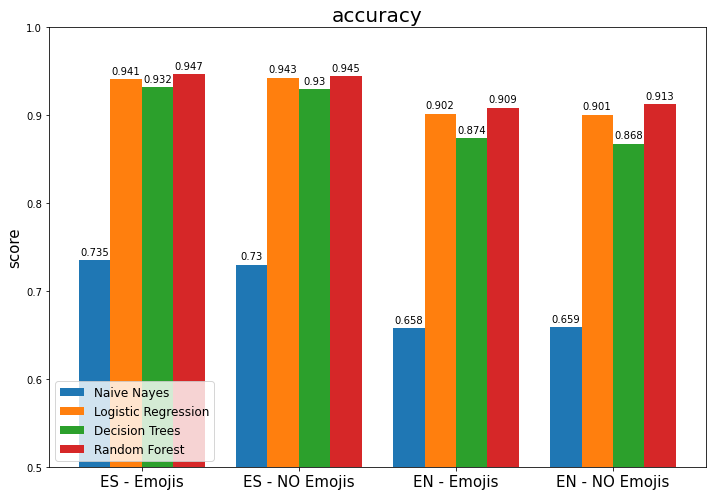

In [34]:
plot_metric('accuracy')

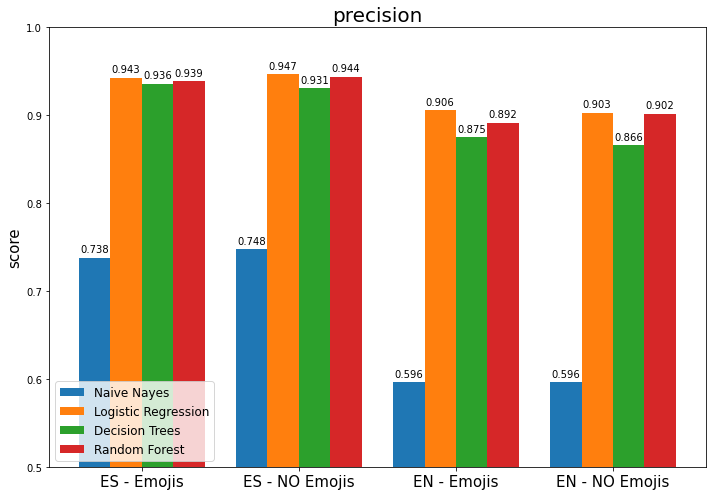

In [35]:
plot_metric('precision')

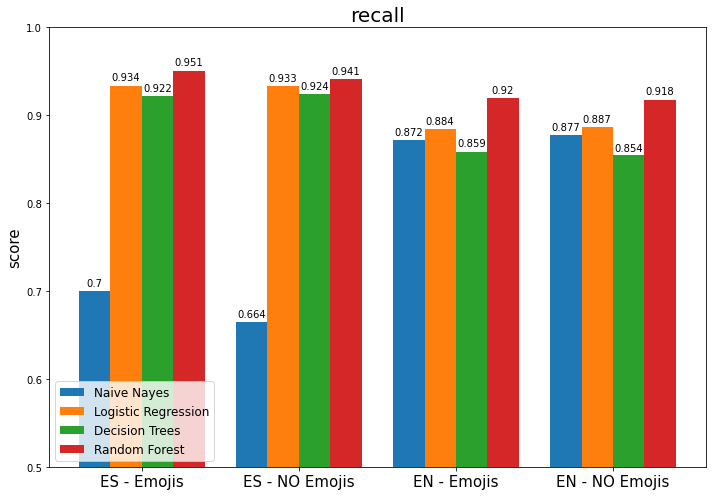

In [36]:
plot_metric('recall')

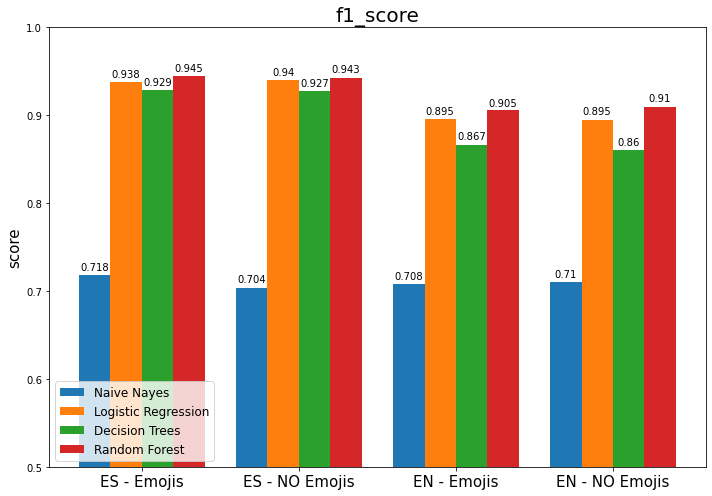

In [37]:
plot_metric('f1_score')

## Feature Importance

### LR Parameters

In [38]:
# Add LR Parameters to ES lexicon Data Frame
es_lexicons['LR Coef'] = LR_Clf_es.coef_[0]

# Add LR Parameters to ES lexicon Data Frame
en_lexicons['LR Coef'] = LR_Clf_en.coef_[0]

In [39]:
# Sort by LR Parameter
es_lexicons.sort_values(by='LR Coef', ascending=False).head(15)

,Term,Id,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),ProposedScore,LR Coef
252,pesar,252,0.015204,0.000084,0.994531,0.005469,0.015120,7.991958
370,pena,370,0.012446,0.000468,0.963749,0.036251,0.011978,6.065036
4511,condolences,4511,0.004013,0.000017,0.995850,0.004150,0.003996,6.056291
2099,peña,2099,0.002014,0.000017,0.991765,0.008235,0.001997,5.926743
2,condolencias,2,0.018370,0.000351,0.981245,0.018755,0.018019,5.617340
434,dolor,434,0.009061,0.000435,0.954219,0.045781,0.008626,5.449742
65,qepd,65,0.018253,0.000836,0.956206,0.043794,0.017417,5.317997
552,luto,552,0.007325,0.006019,0.548916,0.451084,0.001305,4.216845
203,descansa,203,0.003152,0.000117,0.964194,0.035806,0.003035,3.553500
36,pésame,36,0.005647,0.000451,0.925971,0.074029,0.005195,3.547009


In [40]:
# Sort Emojis by LR Parameter
es_lexicons.loc[es_emoji_mask].sort_values(by='LR Coef', ascending=False).head(15)

,Term,Id,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),ProposedScore,LR Coef
50,🙏,50,0.007719,0.001120,0.873259,0.126741,0.006598,1.062547
98,💔,98,0.001226,0.000385,0.761172,0.238828,0.000841,1.011396
3102,💖,3102,0.000117,0.000067,0.635745,0.364255,0.000050,0.871199
210,🕊,210,0.000540,0.000017,0.969960,0.030040,0.000523,0.859069
1443,▶,1443,0.000175,0.000134,0.566911,0.433089,0.000041,0.737054
1803,😟,1803,0.000073,0.000033,0.685699,0.314301,0.000040,0.707306
3851,😉,3851,0.000102,0.000217,0.319680,0.680320,-0.000115,0.699660
130,🏽,130,0.000554,0.000468,0.542194,0.457806,0.000086,0.635822
505,🖤,505,0.000846,0.000268,0.759812,0.240188,0.000579,0.630051
1763,😩,1763,0.000117,0.000234,0.332739,0.667261,-0.000117,0.571138


In [41]:
# Sort by LR Parameter
en_lexicons.sort_values(by='LR Coef', ascending=False).head(15)

,Term,Id,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),ProposedScore,LR Coef
763,sorry,763,0.009685,0.000164,0.983318,0.016682,0.009520,4.711442
10,rip,10,0.026358,0.003779,0.874612,0.125388,0.022579,4.485993
41,condolences,41,0.011648,0.001060,0.916555,0.083445,0.010587,4.006738
1500,grieving,1500,0.001714,0.000119,0.934838,0.065162,0.001595,3.486642
194,heartbreaking,194,0.002095,0.000194,0.915186,0.084814,0.001901,3.481838
1051,alone,1051,0.000791,0.000209,0.790956,0.209044,0.000582,2.908139
798,tributes,798,0.000674,0.000030,0.957559,0.042441,0.000644,2.627325
82,rest,82,0.011750,0.001120,0.912965,0.087035,0.010630,2.249556
582,ripcoronawarriorbadruddin,582,0.000630,0.000045,0.933600,0.066400,0.000585,2.153103
1786,restinpeace,1786,0.000249,0.000015,0.943427,0.056573,0.000234,2.116215


In [42]:
# Sort Emojis by LR Parameter
en_lexicons.loc[en_emoji_mask].sort_values(by='LR Coef', ascending=False).head(15)

,Term,Id,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),ProposedScore,LR Coef
1898,💗,1898,0.000205,0.000015,0.932127,0.067873,0.000190,1.106380
103,😢,103,0.002491,0.000209,0.922550,0.077450,0.002282,1.091225
192,🙏,192,0.011589,0.002240,0.838001,0.161999,0.009349,0.971534
422,😪,422,0.000381,0.000060,0.864429,0.135571,0.000321,0.917170
751,😔,751,0.001480,0.000149,0.908321,0.091679,0.001330,0.905459
985,🕊,985,0.000674,0.000045,0.937661,0.062339,0.000629,0.899510
577,💕,577,0.000322,0.000149,0.683354,0.316646,0.000173,0.727021
3421,🚨,3421,0.000073,0.000179,0.290141,0.709859,-0.000106,0.714043
1131,😡,1131,0.000410,0.000045,0.901532,0.098468,0.000365,0.710542
435,🥺,435,0.000630,0.000403,0.609719,0.390281,0.000227,0.694990


### Mean Decrease Impurity

In [43]:
# Add RF Parameters to ES lexicon Data Frame
es_lexicons['RF Coef'] = RF_Clf_es.feature_importances_

# Add RF Parameters to ES lexicon Data Frame
en_lexicons['RF Coef'] = RF_Clf_en.feature_importances_

In [44]:
# Sort by RF Parameter
es_lexicons.sort_values(by='RF Coef', ascending=False).head(15)

,Term,Id,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),ProposedScore,LR Coef,RF Coef
252,pesar,252,0.015204,0.000084,0.994531,0.005469,0.015120,7.991958,0.088984
65,qepd,65,0.018253,0.000836,0.956206,0.043794,0.017417,5.317997,0.074986
370,pena,370,0.012446,0.000468,0.963749,0.036251,0.011978,6.065036,0.060159
2,condolencias,2,0.018370,0.000351,0.981245,0.018755,0.018019,5.617340,0.052252
4511,condolences,4511,0.004013,0.000017,0.995850,0.004150,0.003996,6.056291,0.034168
434,dolor,434,0.009061,0.000435,0.954219,0.045781,0.008626,5.449742,0.033882
27,familia,27,0.012154,0.001622,0.882271,0.117729,0.010533,0.661662,0.019843
325,dep,325,0.006785,0.001371,0.831894,0.168106,0.005414,2.771015,0.016981
552,luto,552,0.007325,0.006019,0.548916,0.451084,0.001305,4.216845,0.015823
36,pésame,36,0.005647,0.000451,0.925971,0.074029,0.005195,3.547009,0.014766


In [45]:
# Sort Emojis by RF Parameter
es_lexicons.loc[es_emoji_mask].sort_values(by='RF Coef', ascending=False).head(15)

,Term,Id,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),ProposedScore,LR Coef,RF Coef
50,🙏,50,0.007719,0.001120,0.873259,0.126741,0.006598,1.062547,0.010968
99,😔,99,0.002232,0.000769,0.743758,0.256242,0.001463,0.139466,0.002518
98,💔,98,0.001226,0.000385,0.761172,0.238828,0.000841,1.011396,0.001520
3298,😂,3298,0.000525,0.003411,0.133448,0.866552,-0.002886,-0.787059,0.001324
1079,😥,1079,0.000803,0.000184,0.813548,0.186452,0.000619,0.425134,0.001082
1085,😢,1085,0.001605,0.000468,0.774181,0.225819,0.001137,0.308892,0.000992
1325,😞,1325,0.000511,0.000134,0.792441,0.207559,0.000377,-0.814207,0.000741
505,🖤,505,0.000846,0.000268,0.759812,0.240188,0.000579,0.630051,0.000565
209,❤,209,0.001488,0.001170,0.559781,0.440219,0.000318,0.481623,0.000507
177,🏻,177,0.002437,0.002826,0.463040,0.536960,-0.000389,-0.728588,0.000495


In [46]:
# Sort by RF Parameter
en_lexicons.sort_values(by='RF Coef', ascending=False).head(15)

,Term,Id,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),ProposedScore,LR Coef,RF Coef
10,rip,10,0.026358,0.003779,0.874612,0.125388,0.022579,4.485993,0.123516
763,sorry,763,0.009685,0.000164,0.983318,0.016682,0.009520,4.711442,0.047376
82,rest,82,0.011750,0.001120,0.912965,0.087035,0.010630,2.249556,0.030369
41,condolences,41,0.011648,0.001060,0.916555,0.083445,0.010587,4.006738,0.029261
265,loss,265,0.008674,0.000448,0.950878,0.049122,0.008226,1.904769,0.026236
81,peace,81,0.012336,0.004481,0.733561,0.266439,0.007856,2.004635,0.018345
142,family,142,0.010989,0.001822,0.857762,0.142238,0.009166,0.874194,0.016872
62,lost,62,0.009435,0.001120,0.893878,0.106122,0.008315,1.818130,0.014409
194,heartbreaking,194,0.002095,0.000194,0.915186,0.084814,0.001901,3.481838,0.013407
192,🙏,192,0.011589,0.002240,0.838001,0.161999,0.009349,0.971534,0.010195


In [47]:
# Sort Emojis by RF Parameter
es_lexicons.loc[es_emoji_mask].sort_values(by='RF Coef', ascending=False).head(15)

,Term,Id,P(w|c=1),P(w|c=0),P(c=1|w),P(c=0|w),ProposedScore,LR Coef,RF Coef
50,🙏,50,0.007719,0.001120,0.873259,0.126741,0.006598,1.062547,0.010968
99,😔,99,0.002232,0.000769,0.743758,0.256242,0.001463,0.139466,0.002518
98,💔,98,0.001226,0.000385,0.761172,0.238828,0.000841,1.011396,0.001520
3298,😂,3298,0.000525,0.003411,0.133448,0.866552,-0.002886,-0.787059,0.001324
1079,😥,1079,0.000803,0.000184,0.813548,0.186452,0.000619,0.425134,0.001082
1085,😢,1085,0.001605,0.000468,0.774181,0.225819,0.001137,0.308892,0.000992
1325,😞,1325,0.000511,0.000134,0.792441,0.207559,0.000377,-0.814207,0.000741
505,🖤,505,0.000846,0.000268,0.759812,0.240188,0.000579,0.630051,0.000565
209,❤,209,0.001488,0.001170,0.559781,0.440219,0.000318,0.481623,0.000507
177,🏻,177,0.002437,0.002826,0.463040,0.536960,-0.000389,-0.728588,0.000495
